In [1]:
# uncomment the last two cell to clone the data and enable the GPU
#! git clone https://github.com/ParsProgrammer/ERS.git

In [2]:
#cd ERS

# **Packages**

In [3]:
%pip install tensorflow-gpu==2.9
%pip install tensorflow-text

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import tensorflow_text as tf_text

In [5]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import gzip
import gc
import numpy as np
from tensorflow import keras
from sklearn.model_selection import KFold
import datetime 
import os
import matplotlib.pyplot as plt


In [7]:
%pip install gensim==4.2
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api
from nltk.tokenize import sent_tokenize, word_tokenize


In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mobin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else :
  print("No GPU available")

2022-11-30 18:13:31.293210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


1 Physical GPUs, 1 Logical GPUs


2022-11-30 18:13:31.313284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 18:13:31.313467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 18:13:31.314280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 18:13:31.316156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [11]:
%pip install tensorboard
%pip install -U tensorboard_plugin_profile

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# **Data Extraction**

In [12]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    name=b'"verified": \"true\",'
    l=l.replace(b'"verified": true,',bytes(name))
    name1=b'"verified": \"false\",'
    l=l.replace(b'"verified": false,',bytes(name))
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Grocery_and_Gourmet_Food_5.json.gz')

# dataset link
# Grocery and Gourmet Food
# https://jmcauley.ucsd.edu/data/amazon/

Dataset Schema

In [13]:
df.rename(columns={"reviewerID": "userID", "asin": "itemID","overall":"rating"},inplace=True)
df=df[['userID','itemID','reviewText','rating']]
df

,userID,itemID,reviewText,rating
0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4.0
1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3.0
2,A27IQHDZFQFNGG,616719923X,Really good. Great gift for any fan of green t...,4.0
3,A31QY5TASILE89,616719923X,"I had never had it before, was curious to see ...",5.0
4,A2LWK003FFMCI5,616719923X,I've been looking forward to trying these afte...,4.0
...,...,...,...,...
151249,A2L6QS8SVHT9RG,B00KCJRVO2,Delicious gluten-free oatmeal: we tried both t...,4.0
151250,AFJFXN42RZ3G2,B00KCJRVO2,With the many selections of instant oatmeal ce...,4.0
151251,ASEBX8TBYWQWA,B00KCJRVO2,"While I usually review CDs and DVDs, as well a...",5.0
151252,ANKQGTXHREOI5,B00KCJRVO2,My son and I enjoyed these oatmeal packets. H...,4.0


# **Data Splitting**

In [14]:
current_fold=10
kfold = KFold(10)
random_iterator=kfold.split(df)
for i in range(current_fold):
  train_index, test_index = next(random_iterator, None)
  print(train_index,len(train_index))
  train_df, test_df =df.iloc[train_index], df.iloc[test_index]


[ 15126  15127  15128 ... 151251 151252 151253] 136128
[     0      1      2 ... 151251 151252 151253] 136128
[     0      1      2 ... 151251 151252 151253] 136128
[     0      1      2 ... 151251 151252 151253] 136128
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 136126 136127 136128] 136129


In [15]:
train_df

,userID,itemID,reviewText,rating
0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4.0
1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3.0
2,A27IQHDZFQFNGG,616719923X,Really good. Great gift for any fan of green t...,4.0
3,A31QY5TASILE89,616719923X,"I had never had it before, was curious to see ...",5.0
4,A2LWK003FFMCI5,616719923X,I've been looking forward to trying these afte...,4.0
...,...,...,...,...
136124,A74CGCGJ11Y23,B009M516NE,I've made rice pilaf from scratch. I've also t...,4.0
136125,A36MP37DITBU6F,B009M516NE,This is a slightly mild flavored rice pilaf. t...,4.0
136126,A1JBBR4MNGQ70G,B009M516NE,I added a package of Albacore tuna to this mix...,3.0
136127,A2P739KOM4U5JB,B009M516NE,I am happy to report that Side Mates were grea...,4.0


# **Data Analysis**

**User Data**

determining all unique users with their reviews and ratings

In [16]:
user_df=df[['userID','reviewText','rating']].groupby('userID')['rating','reviewText'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
user_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,userID,reviewText,rating
0,A00177463W0XWB16A9O05,[It is a good stand by coffee you can count on...,"[5.0, 5.0, 4.0, 4.0, 5.0, 3.0, 4.0, 5.0, 5.0, ..."
1,A022899328A0QROR32DCT,[awesome texture for even the gluten eating ea...,"[5.0, 1.0, 4.0, 5.0, 5.0, 5.0, 1.0, 2.0, 3.0, ..."
2,A04309042SDSL8YX2HRR7,[I love roasted garlic & sweet bell peppers. Y...,"[5.0, 2.0, 4.0, 4.0, 4.0]"
3,A068255029AHTHDXZURNU,[These bars are especially delicious for cocon...,"[5.0, 5.0, 3.0, 5.0, 3.0, 3.0, 5.0, 5.0, 5.0]"
4,A06944662TFWOKKV4GJKX,[UGH! My stomach has been really killing me l...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0]"
...,...,...,...
14676,AZWRZZAMX90VT,"[Very nice. Not spicy, not too salty, lots of ...","[5.0, 5.0, 2.0, 5.0, 5.0, 4.0, 4.0, 3.0, 4.0, ..."
14677,AZXKAH2DE6C8A,[Could not imagine having such a rich tasting ...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, ..."
14678,AZXON596A1VXC,[I was a bit skeptical when I bought this prod...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
14679,AZYXC63SS008M,[This is just about the healthiest you can get...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"


**Item Data**

determining all unique items with their reviews and ratings

In [17]:
item_df=df[['itemID','reviewText','rating']].groupby('itemID')['reviewText','rating'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
item_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,itemID,reviewText,rating
0,616719923X,[Just another flavor of Kit Kat but the taste ...,"[4.0, 3.0, 4.0, 5.0, 4.0, 4.0, 3.0, 5.0, 5.0, ..."
1,9742356831,[This curry paste makes a delicious curry. I ...,"[5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
2,B00004S1C5,[These dyes create awesome colors for kids cra...,"[5.0, 1.0, 5.0, 5.0, 5.0, 4.0, 4.0]"
3,B0000531B7,[I really enjoy these bars as a quick breakfas...,"[5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0]"
4,B00005344V,"[Traditional Medicinals' ""Breathe Easy"" is an ...","[5.0, 3.0, 5.0, 5.0, 3.0, 5.0, 5.0]"
...,...,...,...
8708,B00JGPG60I,[We switched to this formula 5 days ago and fo...,"[4.0, 4.0, 4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 2.0, ..."
8709,B00JL6LTMW,[We have enjoyed Larabar's variety of bars for...,"[4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, ..."
8710,B00K00H9I6,[This 100% pure Canadian maple syrup is a Grad...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
8711,B00KC0LGI8,[I followed the directions on the box exactly ...,"[2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 2.0, 5.0, 3.0, ..."


##   Ratings

count    151254.000000
mean          4.243042
std           1.090003
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

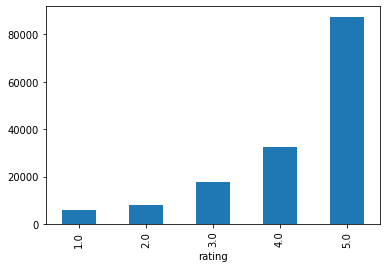

In [18]:
df.groupby('rating').size().plot(kind="bar");
df['rating'].describe()
#histogram of ratings

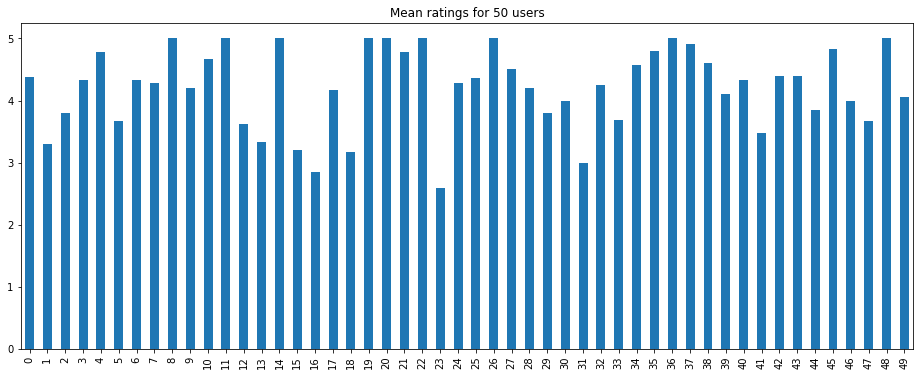

In [19]:
user_means=user_df.rating.apply(lambda x: np.mean(x))
user_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 users");

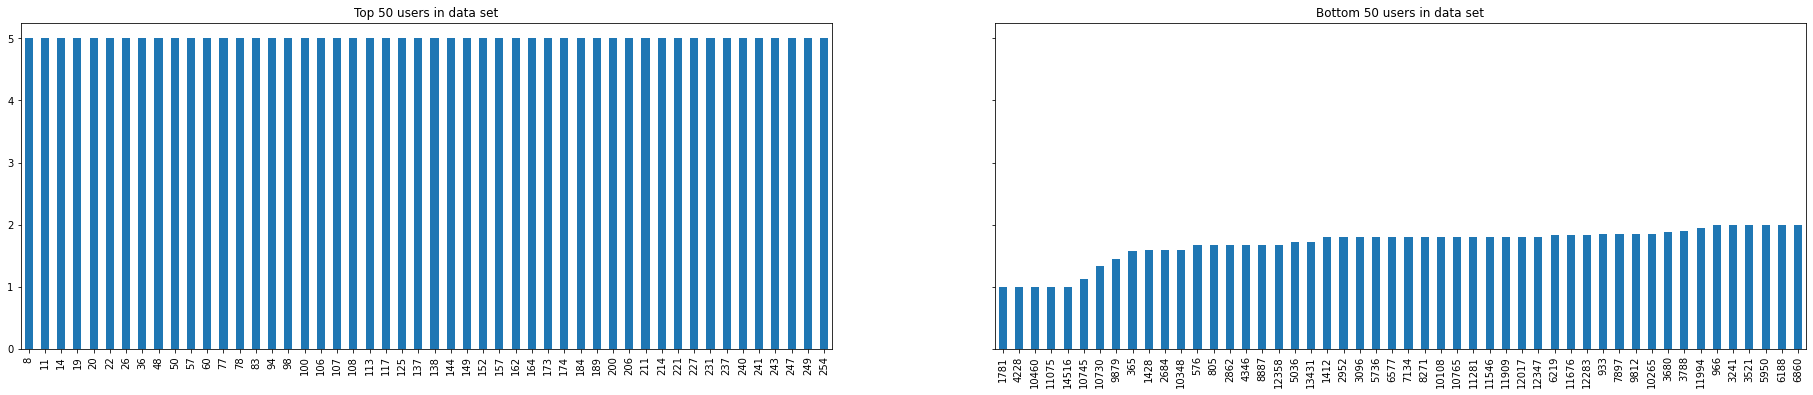

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,6), sharey=True)
user_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 users in data set")
user_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 users in data set");

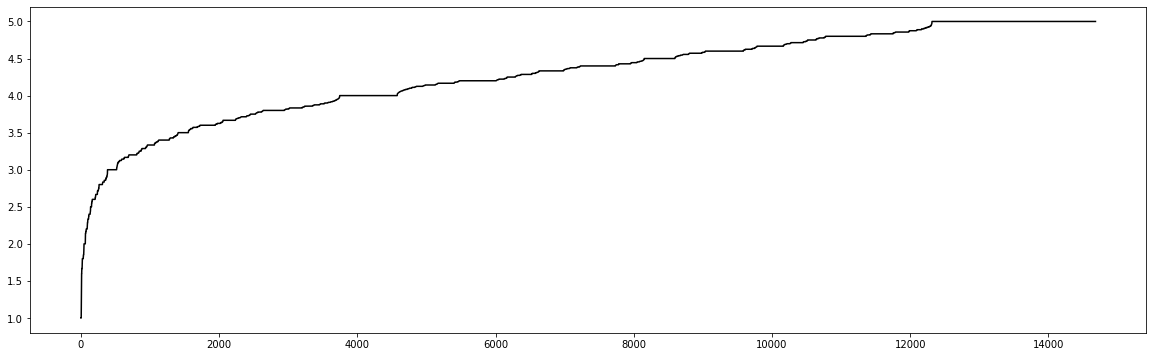

In [21]:
user_means = df.groupby("userID").rating.mean().sort_values()
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(np.arange(len(user_means)), user_means.values, "k-")


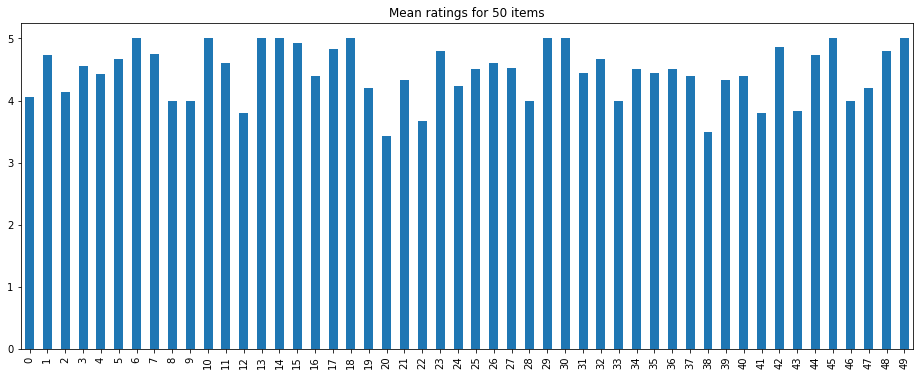

In [22]:
item_means=item_df.rating.apply(lambda x: np.mean(x))
item_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 items");

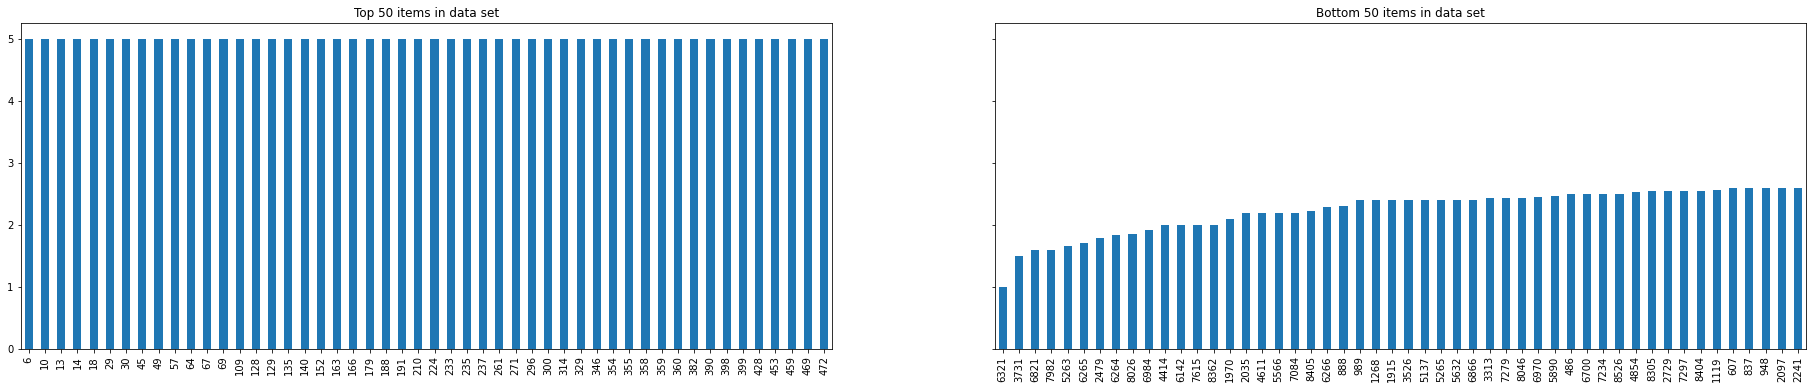

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,6), sharey=True)
item_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 items in data set")
item_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 items in data set");

## Reviews

In [24]:
df['reviewText'].describe()

count     151254
unique    151199
top             
freq          22
Name: reviewText, dtype: object

count    151254.000000
mean        509.002142
std         524.745639
min           0.000000
25%         191.000000
50%         353.000000
75%         644.000000
max       29569.000000
Name: reviewText, dtype: float64

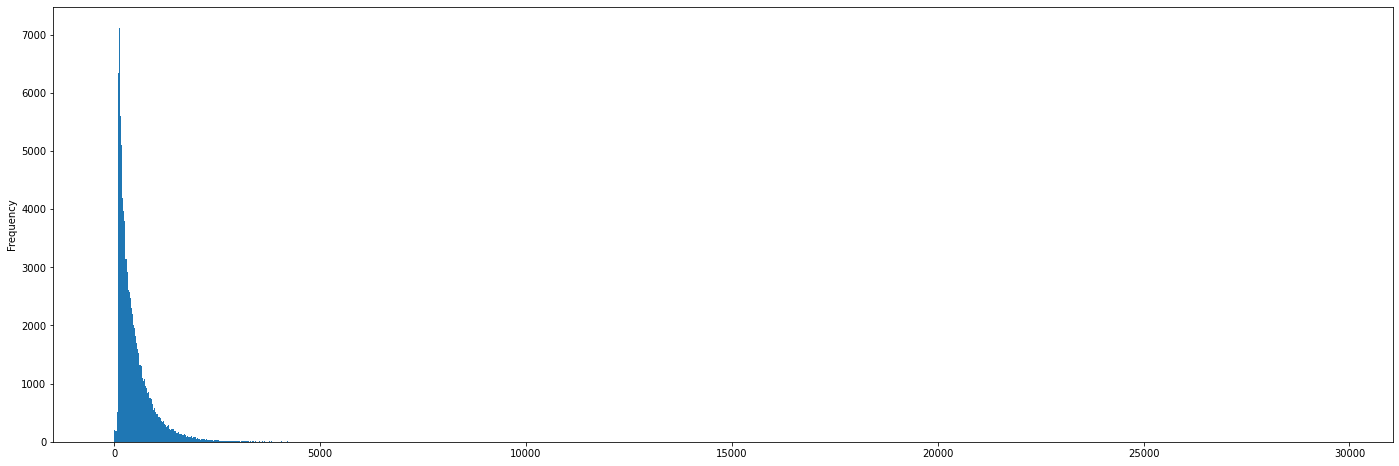

In [25]:
# review length
rv_le=df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()


In [26]:
sum=0
sum2=0
for x in user_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(user_df['reviewText'])
w_mean=sum2/(r_mean*len(user_df['reviewText']))
print('mean of reviews per user:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per user:',r_mean * w_mean)
# plot for reviews per user

mean of reviews per user: 10.302704175464887
mean of words per review: 509.00214209211
mean of words per user: 5244.098494652953


In [27]:
sum=0
sum2=0
for x in item_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(item_df['reviewText'])
w_mean=sum2/(r_mean*len(item_df['reviewText']))
print('mean of reviews per item:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per item:',r_mean * w_mean)

mean of reviews per item: 17.359577642603007
mean of words per review: 509.00214209211
mean of words per item: 8836.062205899232


# **Embedding Matrix**

In [28]:
# hyperparameters
embedding_dim=300
min_frequent_word_num=1
max_vocab_size=5000
sequence_length=50

In [29]:
def tf_lower_and_split_punct(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text= tf.strings.reduce_join( tf.strings.split(text)[:,:sequence_length-2],axis=-1,separator=' ')
  return  text.numpy()

In [30]:
with tf.device('/CPU:0'):
    user_corpus =list(map(tf_lower_and_split_punct,user_df['reviewText'])) 
    item_corpus = list( map(tf_lower_and_split_punct,item_df['reviewText']) )

In [31]:
def load_word2vec_model():
    if os.path.exists("word2vec.wordvectors"):
        print("loaded from word2vec.wordvectors")
        return KeyedVectors.load("word2vec.wordvectors",mmap='r')
    else:
        # downloading google news word2vec model
        if not os.path.exists("word2vec_google.bin"):
            downloaded_model = api.load('word2vec-google-news-300')
            downloaded_model.save_word2vec_format('word2vec_google.bin',binary=True)
            del downloaded_model
        # loading google news word2vec model
        google_word2vec = KeyedVectors.load_word2vec_format("word2vec_google.bin", binary=True)

       # tokenizing the whole reviews in text_corpus
        text_corpus=[]
        for i,doc in enumerate(user_corpus):    # iterate through each sentence in the reviews
            for rv in doc:
                for sen in sent_tokenize(rv.decode("utf-8")):
                    temp = []
                    # tokenize the sentence into words          
                    for j in word_tokenize(sen):
                        temp.append(j.lower())
                    text_corpus.append(temp)
                    del temp


        # creating a new word2vec model and initializing it from pretrained google_word2vec
        word2vec_model=Word2Vec( text_corpus,max_final_vocab=max_vocab_size,min_count=min_frequent_word_num ,vector_size= embedding_dim,window = 1,workers=16, sg=1,epochs=1)
        word2vec_model.build_vocab(text_corpus)

        word2vec_model.build_vocab([google_word2vec.index_to_key],update=True)
        word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv))
        word2vec_model.wv.intersect_word2vec_format("word2vec_google.bin",binary=True,lockf=1.0)
        
        # fine tuning the model and saving it
        word2vec_model.train(text_corpus, epochs=5, total_examples=word2vec_model.corpus_count)
        word2vec_model.wv.save("word2vec.wordvectors")
        
        del google_word2vec
        del text_corpus[:]
        gc.collect()
  
        return word2vec_model.wv
        

In [32]:
# loading the embedding lookup matrix shape=( 5k ,300 )
embedding_matrix = load_word2vec_model() 
print( "embedding matrix shape : (",len(embedding_matrix.index_to_key)," ,",embedding_matrix.vector_size,")")

loaded from word2vec.wordvectors
embedding matrix shape : ( 4994  , 300 )


In [33]:
embedding_matrix.index_to_key

['.',
 'i',
 'the',
 ',',
 'a',
 'and',
 'to',
 'it',
 'this',
 'is',
 'of',
 'for',
 'in',
 'my',
 'but',
 'that',
 'are',
 'not',
 'with',
 'have',
 'like',
 'these',
 'was',
 'good',
 'you',
 '!',
 'as',
 'they',
 'taste',
 'so',
 'on',
 'flavor',
 'great',
 'coffee',
 'very',
 'love',
 'its',
 'just',
 'one',
 'them',
 'or',
 'be',
 'tea',
 'at',
 'all',
 'has',
 'when',
 'really',
 'product',
 'can',
 'if',
 'we',
 'me',
 'from',
 'had',
 'more',
 'than',
 'use',
 'too',
 'some',
 'chocolate',
 'would',
 'much',
 'tried',
 'no',
 'ive',
 'dont',
 'little',
 'other',
 'an',
 'get',
 'out',
 'will',
 'im',
 'about',
 'make',
 'am',
 'because',
 'sweet',
 'been',
 'up',
 'were',
 'there',
 'only',
 'what',
 'nice',
 'best',
 'drink',
 'time',
 'price',
 'tastes',
 'better',
 'buy',
 'first',
 'well',
 'sugar',
 'try',
 'water',
 'eat',
 'do',
 'delicious',
 'used',
 'which',
 'also',
 'by',
 'find',
 'your',
 'snack',
 'even',
 'tasty',
 'favorite',
 'organic',
 'bought',
 'cup',
 'a

In [34]:
# exact vocab_size is equal to full_embedding_matrix shape[0]
special_token_embedding = np.random.rand(4,embedding_matrix.vector_size)
full_embedding_matrix = np.concatenate((special_token_embedding,embedding_matrix.vectors))
full_embedding_matrix.shape

(4998, 300)

In [35]:
# example
# embedding_matrix['keep']

# **Text Vectorization**

In [36]:
# hyperparameter

batch_size=32
num_batches=int(train_df.shape[0]/batch_size)
num_batches_test=int(test_df.shape[0]/batch_size)
print("number of batches in train data",num_batches)
print("number of batches in test data",num_batches_test)

number of batches in train data 2127
number of batches in test data 236


## **Preprocessing**

In [37]:
def tf_lower_and_split_punct_enc(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text


def tf_lower_and_split_punct_decin(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text], separator=' ') 
  return text


def tf_lower_and_split_punct_decout(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join([ text, '[END]'], separator=' ')
  return text



## Vectorization layer

- The conversion of tokens to ids

In [38]:
enc_input_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_enc,
                                                     output_sequence_length = sequence_length,  )
dec_input_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_decin,
                                                     output_sequence_length = sequence_length,  )

dec_output_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_decout,
                                                     output_sequence_length = sequence_length,  )

In [39]:
enc_input_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )
dec_input_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )
dec_output_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )

In [40]:
print(enc_input_processor.get_vocabulary().index('caused'))
print(enc_input_processor.get_vocabulary()[3351])

3351
caused


In [41]:
# included sos, eos, unk and space 
print("input_text_processor vocab size :" ,len(enc_input_processor.get_vocabulary()))
# Here are the first 16 words from the vocabulary:
print(enc_input_processor.get_vocabulary()[:16])
print(df['reviewText'][0])
print(dec_output_processor(  df['reviewText'][0]))

input_text_processor vocab size : 4998
['', '[UNK]', '[START]', '[END]', '.', 'i', 'the', ',', 'a', 'and', 'to', 'it', 'this', 'is', 'of', 'for']
Just another flavor of Kit Kat but the taste is unique and a bit different.  The only thing that is bothersome is the price.  I thought it was a bit expensive....
tf.Tensor(
[  41  343   35   14 1318 4889   18    6   32   13 1010    9    8  120
  150    4    6   87  267   19   13    1   13    6   93    4    5  157
   11   26    8  120  354    4    4    4    4    3    0    0], shape=(40,), dtype=int64)


# **TF-IDF Matrix**

In [42]:
with tf.device('/CPU:0'):

  tfidf_calculator = tf.keras.layers.TextVectorization(

    max_tokens  = max_vocab_size,
    output_mode ='tf-idf',
    pad_to_max_tokens = True  
    )
  tfidf_calculator.adapt(enc_input_processor.get_vocabulary()[:] )
  print("the length of tf-idf vocab",len(tfidf_calculator.get_vocabulary()))
  print( list(set(enc_input_processor.get_vocabulary())-set(tfidf_calculator.get_vocabulary()))[:9])
  print( list(set(embedding_matrix.index_to_key)-set(tfidf_calculator.get_vocabulary()))[:9])


the length of tf-idf vocab 4992
['', '!', '[START]', '.', '[END]', ',', '?']
['?', '!', '.', ',']


In [43]:
# with tf.device('/CPU:0'):

#     user_tfidf = list( map(tfidf_calculator, user_corpus))
#     item_tfidf = list( map(tfidf_calculator, item_corpus))


# **Forming Dataset**

In [44]:
# convert string id to int id
user_to_row = {}
item_to_column = {}

for i, user_id in enumerate(np.unique(df['userID'])):
    user_to_row[user_id] = i

for j, item_id in enumerate(np.unique(df['itemID'].tolist())):
    item_to_column[item_id] = j

In [77]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (
       [user_to_row[dp] for dp in train_df['userID']],
       [item_to_column[dp] for dp in train_df['itemID']],
       tf.cast(train_df['rating'],dtype=tf.int8),
       tf.cast(dec_input_processor(train_df['reviewText']),dtype=tf.int32),
       tf.cast(dec_output_processor(train_df['reviewText']),dtype=tf.int32)       
    )
).shuffle(1024).batch(batch_size,drop_remainder=True)
test_ds = tf.data.Dataset.from_tensor_slices(
    (
      [user_to_row[dp] for dp in test_df['userID']],
      [item_to_column[dp] for dp in test_df['itemID']],
      tf.cast(test_df['rating'],dtype=tf.int8),
      tf.cast(dec_input_processor(test_df['reviewText']),dtype=tf.int32),
      tf.cast(dec_output_processor(test_df['reviewText']),dtype=tf.int32)     
     
    )
).shuffle(1024).batch(batch_size,drop_remainder=True)

In [46]:
train_data_num=train_df.shape[0]
test_data_num=test_df.shape[0]
print("train and test data number : ",train_data_num," , ",test_data_num)

train and test data number :  136129  ,  15125


In [47]:
for i in train_ds.take(1):
    print(i)

(<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([ 1129, 11256,  8686, 10127, 10169,  1456, 11282,  8405,  4277,
         789,   957, 14050, 10009, 13500,  1304,   160,  5237,  1513,
        3053, 14582, 14630,  2831,  5588,  5292, 14114,  8488,  8208,
       11991, 10025, 12228,  6598, 11393, 10674,  8454,  6475,  2077,
        7887,  6494,  5199,  4598,  4794,  9551,  3631,  6916,  8360,
        6451,   731,  8295,  7315,  2177, 10145,  7546,   779,  4697,
         527, 11191, 10976, 10599,  1953,  9045, 10463,  9444,   548,
        5887], dtype=int32)>, <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([63, 75, 51, 31, 34, 77, 80, 27, 83, 31, 27, 56, 58, 86,  6, 65,  7,
       19, 65, 31, 67, 11, 65, 68, 58, 80, 58, 79, 30, 58, 19, 54,  1, 84,
       58, 26, 12, 65, 93, 51, 27, 20, 77, 65, 65, 40, 90, 95, 26, 16,  5,
       52, 30, 22,  0, 65, 33, 58, 20, 58, 36, 45, 65, 89], dtype=int32)>, <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([4, 3, 5, 5, 5, 2, 4, 5, 5, 4, 5, 5, 5

# **User and Item Documents**

**User Documents**

In [48]:
user_doc = list( map(enc_input_processor,[doc for doc in user_df['reviewText']]))

**Item Documents**

In [49]:
item_doc = list( map(enc_input_processor,[doc for doc in item_df['reviewText']]))

In [50]:
user_doc[0][0]

<tf.Tensor: shape=(40,), dtype=int64, numpy=
array([   2,   11,   13,    8,   27, 1133,  108,   37,   28,   53,  825,
         34,    4,    5,   65,    1,   34,   11,   15,    6,  677,   61,
          1,    4,    3,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])>

Text(0.5, 1.0, 'Mask')

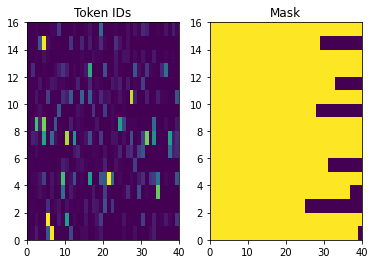

In [51]:
plt.subplot(1, 2, 1)
plt.pcolormesh(item_doc[0])
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(item_doc[0] != 0)
plt.title('Mask')

### Converting ID to Vector

In [52]:
user_df['reviewText'][0][0]

'It is a good stand by coffee you can count on.  I would reley on it for the daily use catagory.'

In [53]:
input_vocab = enc_input_processor.get_vocabulary()
" ".join([input_vocab[id] for id in user_doc[0][0]])


'[START] it is a good stand by coffee you can count on . i would [UNK] on it for the daily use [UNK] . [END]               '

# **Context-aware Matrix Factorization for Rating Prediction**

In [54]:
#hyperparameters
num_users=len(user_to_row)
num_items=len(item_to_column)
mean_inv = np.float32( train_df['rating'].mean())



In [55]:
feature_num=64 # number of topics
units=int(feature_num/2 )# gru units

In [56]:
# del df
# del user_df
# del item_df
# del user_corpus[:]
# del item_corpus[:]
# del train_df
# del test_df

# gc.collect()
# gc.collect(0)
# gc.collect(1)
# gc.collect(2)

In [57]:
user_specific_vector = tf.Variable(np.zeros(shape=(num_users, feature_num),dtype=np.float32)) 
item_specific_vector = tf.Variable(np.zeros(shape=(num_items, feature_num),dtype=np.float32)) 

## **PMF (Probabilistic Matrix Factorization)**

In [58]:
class PMF():
    def __init__(self, num_feat=16, epsilon=1, _lambda=0.1, momentum=0.8,  num_batches=152, batch_size=1000,num_item=9000,num_user=15000,mean_inv=3):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.num_item=num_item
        self.num_user=num_user
        self.V =  0.1 * np.random.randn(self.num_item, self.num_feat).astype(np.float64)  # Item feature vectors
        self.U =  0.1 * np.random.randn(self.num_user, self.num_feat).astype(np.float64)  # User feature vectors
        self.V_inc = np.zeros((self.num_item, self.num_feat),dtype=np.float64)
        self.U_inc = np.zeros((self.num_user, self.num_feat),dtype=np.float64)
        self.rmse_train = []
        self.rmse_test = []
        self.mean_inv= mean_inv  
        
    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    def train(self):
          
            for batch in range(self.num_batches):  
                
                (batch_UserID,batch_ItemID, batch_rating ,_,_) = next(iter(train_ds))
      
                # Compute Objective Function
               
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                              self.V[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply
                
                rawErr = pred_out - batch_rating.numpy() + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.V[batch_ItemID, :]) \
                       + self._lambda * (self.U[batch_UserID, :] - tf.gather(user_specific_vector,batch_UserID).numpy())
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.U[batch_UserID, :]) \
                       + self._lambda * (self.V[batch_ItemID, :] -  tf.gather(item_specific_vector,batch_ItemID).numpy()) 
                       # np.newaxis :increase the dimension
               
                dw_Item = np.zeros((self.num_item, self.num_feat))
                dw_User = np.zeros((self.num_user, self.num_feat))
                
                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
              
                self.V_inc = self.momentum * self.V_inc + self.epsilon * dw_Item / self.batch_size
                self.U_inc = self.momentum * self.U_inc + self.epsilon * dw_User / self.batch_size
                
                self.V = self.V - self.V_inc
                self.U = self.U - self.U_inc
            
                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    rawErr=np.zeros((self.batch_size),dtype=np.float32).tolist()
                    for batch_UserID,batch_ItemID, batch_rating ,_,_ in train_ds:
                        
                        
                        pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                              self.V[batch_ItemID, :]),
                                     axis=1)  # mean_inv subtracted

                        rawErr += pred_out - batch_rating.numpy() + self.mean_inv
                    # pred_out = np.sum(np.multiply(self.U[np.array(train_data['userid'], dtype='int32'), :],
                    #                               self.V[np.array(train_data['itemid'], dtype='int32'), :]),
                    #                   axis=1)  # mean_inv subtracted
                    # rawErr = pred_out - train_data['rating'] + self.mean_inv
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.U - user_specific_vector) ** 2 + np.linalg.norm(self.V - item_specific_vector) ** 2)
                   # print("1***************\n",self.U.shape)
                   # print("2***************\n",user_specific_vector.shape)
                    self.rmse_train.append(np.sqrt(obj / train_data_num))

                # Compute validation error
                if batch == self.num_batches - 1:
                    rawErr=np.zeros((self.batch_size),dtype=np.float32).tolist()
                    for batch_UserID,batch_ItemID, batch_rating ,_,_ in test_ds:
                        pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                              self.V[batch_ItemID, :]),
                                     axis=1)  # mean_inv subtracted

                        rawErr += pred_out - batch_rating.numpy() + self.mean_inv
                    # pred_out = np.sum(np.multiply(self.U[np.array(test_data['userid'], dtype='int32'), :],
                    #                               self.V[np.array(test_data['itemid'], dtype='int32'), :]),
                    #                   axis=1)  # mean_inv subtracted
                    # rawErr = pred_out - test_data['rating'] + self.mean_inv
                   
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(test_data_num))

                    # Print info
                    if batch == self.num_batches - 1:
                        print('\nTraining RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))

    def predict(self, invID):
        return np.dot(self.V, self.U[int(invID), :]) + self.mean_inv  # numpy.dot 点乘

    # ****************Set parameters by providing a parameter dictionary.  ***********#

    def topK(self, test_data, k=10):
        inv_lst = np.unique(test_data[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]  # numpy.argsort

        intersection_cnt = {}
        for i in range(test_data.shape[0]):
            if test_data[i, 1] in pred[test_data[i, 0]]:
                intersection_cnt[test_data[i, 0]] = intersection_cnt.get(test_data[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_data[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)


# **Adversarial Seq2Seq Learning**

## **Metrics**

In [59]:
# log files for training and test
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
graph_log_dir = 'logs/graph/' + current_time 
graph_summary_writer = tf.summary.create_file_writer(graph_log_dir)

In [60]:
class PerplexityMetric(tf.keras.metrics.Metric):
    def __init__(self,name='perplexity',**kwargs):
        super().__init__(name=name, **kwargs)
        self.perplexity=self.add_weight(name='pl',initializer='zeros')

    def update_state(self, nll_loss):
        self.perplexity= 2 ** nll_loss

    def result(self):
        return self.perplexity

In [61]:
train_plx_gen_tch = PerplexityMetric(name='generator perplexity')  # teacher forcing mode
train_plx_gen_plc = PerplexityMetric(name='generator perplexity')  # policy gradient mode
train_acc_dis = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

test_plx_gen = PerplexityMetric(name='generator perplexity')  



## **Recurrent Review Generator**

- it consists of two encoders and one decoder

### **Encoder**

In [62]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,vocab_size, embedding_dim, enc_units):
    super().__init__()
    self.enc_units = enc_units
    self.embedding_dim=embedding_dim
    self.vocab_size = vocab_size
    
    self.embedding = tf.keras.layers.Embedding( self.vocab_size, self.embedding_dim, embeddings_initializer=keras.initializers.Constant(full_embedding_matrix),trainable=False)
    self.gru= tf.keras.layers.Bidirectional(tf.keras.layers.GRU(  self.enc_units,return_state=True,  recurrent_initializer='glorot_uniform' ))


  def call(self, reviews, state=None):
    vectors = self.embedding(reviews)
    _,encoder_forward_state,encoder_backward_state  = self.gru(vectors, initial_state=state)
 
    return  tf.concat([ encoder_forward_state, encoder_backward_state],-1)

    

### **Decoder (Generator)**

In [63]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,vocab_size, embedding_dim, dec_units):
    super().__init__()
    self.dec_units = dec_units
    self.embedding_dim = embedding_dim
    self.vocab_size = vocab_size
    
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim,embeddings_initializer=keras.initializers.Constant(full_embedding_matrix), trainable=False)
    self.gru=tf.keras.layers.GRU( self.dec_units , return_state=True,return_sequences=True)
    self.fc = tf.keras.layers.Dense(self.vocab_size, use_bias=False)
    self.sf=tf.keras.layers.Activation('softmax')

  def call(self, decoder_input, context_vector,state=None):

     embedded_input = self.embedding(decoder_input)
     joint_input_context = tf.concat([embedded_input, tf.tile(tf.expand_dims(context_vector,1),[1,embedded_input.shape[1],1])],2 )
     outputs,dec_state = self.gru(joint_input_context, initial_state=state)
     logits = self.fc( outputs)
     prob_dist = self.sf(logits)

     return prob_dist,dec_state


In [64]:
class GeneratorLoss(tf.keras.losses.Loss):
  def __init__(self,vocab_size):
    self.name = 'masked_loss'
    self.vocab_size=vocab_size
  def __call__(self, y_true, y_pred):
    # Calculating the loss for a batch of reviews.

    mask = tf.cast(y_true != 0, tf.int32)
    maskoff_ind=tf.reduce_sum(mask)
    a=tf.one_hot(y_true[:maskoff_ind],self.vocab_size, 1.0, 0.0)
    b=tf.math.log( tf.clip_by_value(y_pred[:maskoff_ind], 1e-20, 1.0))
    #print(y_true)
    #print("\n\n\n",a)
    #print("\n\n\n",b)
    c=a * b
   # print("\n\n\n",c)
    loss=-tf.reduce_sum(c) /tf.cast(maskoff_ind,dtype=tf.float32)
   # print(loss)
    return loss

## **Discriminator**

In [65]:
class Discriminator(tf.keras.Model):
    def __init__( self, sequence_length, vocab_size, embedding_dim, filter_sizes, num_filters, l2_reg_lambda=0.0):
      super().__init__()
      self.sequence_length=sequence_length
      self.vocab_size=vocab_size
      self.embedding_dim=embedding_dim
      self.filter_sizes=filter_sizes
      self.num_filters= num_filters

      self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim,weights=[full_embedding_matrix],name="discriminator_embedding",trainable=False)
     
      self.conv_unigram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[0], activation="tanh",name="conv_unigram")
      self.conv_bigram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[1],activation="tanh",name="conv_bigram")
      self.conv_trigram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[2],activation="tanh",name="conv_trigram")
      self.conv_fourgram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[3],activation="tanh",name="conv_fourgram")
      self.conv_fivegram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[4],activation="tanh",name="conv_fivegram")

      self.gmp_unigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_unigram")
      self.gmp_bigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_bigram")
      self.gmp_trigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_trigram")
      self.gmp_fourgram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_fourgram")
      self.gmp_fivegram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_fivegram")

      self.dropout=tf.keras.layers.Dropout(.5,name="dropout")
      self.fc=tf.keras.layers.Dense(1,activation="sigmoid")


    def get_reward(self, discriminator_inputs , context_vector,training=False ):
      
      embedded_input= self.embedding(discriminator_inputs)
      joint_input_context =tf.concat([embedded_input, tf.tile(tf.expand_dims(context_vector,1),[1,embedded_input.shape[1],1])],2 )

      cv_unigram=self.conv_unigram(joint_input_context)
      cv_bigram=self.conv_bigram(joint_input_context)
      cv_trigram=self.conv_trigram(joint_input_context)
      cv_fourgram=self.conv_fourgram(joint_input_context)
      cv_fivegram=self.conv_fivegram(joint_input_context)

      gmp_unigram = self.gmp_unigram(cv_unigram)
      gmp_bigram = self.gmp_bigram(cv_bigram)
      gmp_trigram =  self.gmp_trigram(cv_trigram)
      gmp_fourgram = self.gmp_fourgram(cv_fourgram)
      gmp_fivegram = self.gmp_fivegram(cv_fivegram)
    
      gmp_overal = tf.concat([gmp_unigram,gmp_bigram,gmp_trigram,gmp_fourgram,gmp_fivegram],1)
      
      if training:
        dropout = self.dropout(gmp_overal,training=training)
        ath= self.fc(dropout)
      else:
        ath= self.fc(gmp_overal)

      gc.collect()
      return ath[:,0]


In [66]:
class DiscriminatorLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'cross-entropy_loss'
    self.binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy( reduction='none')

  def __call__(self, y_true, y_pred):
    loss = self.binary_cross_entropy_loss(y_true, y_pred)
    return loss

## **Adversarial Training**

In [67]:
#hyperparameter
t_step=1 # teacher forcing training number
g_step=1 # generator training number
d_step=3 # discriminator training number
rollout_num=1


In [68]:
class MaskedLossReward(tf.keras.losses.Loss):
  def __init__(self,vocab_size):
    self.name = 'masked_loss_reward'
    self.vocab_size=vocab_size
  def __call__(self, y_true, y_pred,reward):
    # Calculate the loss for each step.

    mask = tf.cast(y_true != 0, tf.int32)
    maskoff_ind=tf.reduce_sum(mask)

    loss=- tf.reduce_sum( tf.reduce_sum( tf.one_hot(y_true[:maskoff_ind], self.vocab_size, 1.0, 0.0)
      * tf.math.log( tf.clip_by_value(y_pred[:maskoff_ind], 1e-20, 1.0)),2) * reward[:maskoff_ind]) / tf.cast(maskoff_ind,dtype=tf.float32)
    return loss

In [69]:
class Seq2Seq(tf.keras.Model): 
    def __init__(self,num_topic, units ,embedding_dim,vocab_size ,sequence_length, num_batches, batch_size, use_tf_function=False):
        super().__init__()
        self.use_tf_function = use_tf_function
        self.num_batches = num_batches
        self.batch_size = batch_size
        self.num_topic=num_topic
        self.embedding_dim = embedding_dim
        self.units=units
        self.vocab_size=vocab_size
        self.sequence_length=sequence_length


        self.user_encoder = Encoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, enc_units= self.units)
        self.item_encoder = Encoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, enc_units= self.units)
        self.decoder = Decoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, dec_units= 4 * self.units) #generator
        self.discriminator = Discriminator(sequence_length= self.sequence_length, vocab_size= self.vocab_size,embedding_dim= self.embedding_dim, filter_sizes= [1, 2, 3 ,4, 5] ,num_filters=128)
      
        self.loss_gn = GeneratorLoss(vocab_size=self.vocab_size)
        self.loss_ds = DiscriminatorLoss()
        self.loss_fn = MaskedLossReward(vocab_size=self.vocab_size) # generator loss with reward

        self.optimizer_gn=tf.optimizers.Adam()
        self.optimizer_ds=tf.optimizers.Adam()


    def _train_step_gn_teacher(self, batch_userdoc,batch_itemdoc,userdoc_slice_idx, itemdoc_slice_idx,batch_review_in,batch_review_out):
           
            with tf.GradientTape() as tape:
              user_enc_state = self.user_encoder(batch_userdoc) # user vector representations      
              item_enc_state = self.item_encoder(batch_itemdoc) # item vector representations
              # predicted features [batch_size, num_topics]
              user_context_vector = tf.stack([ tf.reduce_mean(user_enc_state[ userdoc_slice_idx[sl_num] : userdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(batch_size)])
              item_context_vector = tf.stack([ tf.reduce_mean(item_enc_state[ itemdoc_slice_idx[sl_num] : itemdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(batch_size)])
              context_vector = tf.concat( [user_context_vector,item_context_vector],1)

              # regularization must take place here  
              dec_pred, _ = self.decoder( batch_review_in , context_vector)             
              loss = self.loss_gn(batch_review_out , dec_pred)
           
            variables = self.user_encoder.trainable_variables + self.item_encoder.trainable_variables + self.decoder.trainable_variables
            gradients = tape.gradient(loss,variables)
            self.optimizer_gn.apply_gradients(zip(gradients, variables))          
            
            print("gen batch loss in supervised training", loss)   
            train_plx_gen_tch.update_state(loss)
  
    def _test_step_generator(self, batch_userdoc,batch_itemdoc,userdoc_slice_idx, itemdoc_slice_idx):
            
            user_enc_state = self.user_encoder(batch_userdoc) # user vector representations      
            item_enc_state = self.item_encoder(batch_itemdoc) # item vector representations
                
            user_context_vector = tf.stack([ tf.reduce_mean(user_enc_state[ userdoc_slice_idx[sl_num] : userdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(batch_size)])
            item_context_vector = tf.stack([ tf.reduce_mean(item_enc_state[ itemdoc_slice_idx[sl_num] : itemdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(batch_size)])
            context_vector = tf.concat( [user_context_vector,item_context_vector],1)

            dec_out = [tf.convert_to_tensor(batch_size * [[2]])] 
            dec_prob=[]
            dec_state=None
            for _ in range(self.self.sequence_length):           
                d_prob,dec_state = self.decoder( dec_out[-1], context_vector ,dec_state)
                dec_prob.append(d_prob[:,-1])          
                dec_out.append(tf.random.categorical(d_prob[:,-1],1,dtype=tf.int32))            
                del d_prob
            predicted_samples = tf.squeeze(tf.stack(dec_out,1))

            loss = self.loss_gn(predicted_samples[:,1:] ,tf.transpose( tf.stack(dec_prob), [1,0,2])  )
            print("gen batch loss in test: ",loss)
            test_plx_gen.update_state(loss)

    def _train_step_gn_policy(self, batch_userdoc, batch_itemdoc, userdoc_slice_idx, itemdoc_slice_idx):
            
            with tf.GradientTape() as tape:
              user_enc_state = self.user_encoder(batch_userdoc) # user vector representations      
              item_enc_state = self.item_encoder(batch_itemdoc) # item vector representations
                
              user_context_vector = tf.stack([ tf.reduce_mean(user_enc_state[ userdoc_slice_idx[sl_num] : userdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(batch_size)])
              item_context_vector = tf.stack([ tf.reduce_mean(item_enc_state[ itemdoc_slice_idx[sl_num] : itemdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(batch_size)])
              context_vector = tf.concat( [user_context_vector,item_context_vector],1)
              # computing context vector
        
              dec_state=None
              dec_prob=[]
              # generating samples
              dec_out = [tf.convert_to_tensor(batch_size * [[2]])] # initilize generated_sample with sos token(2)
              for _ in range(sequence_length):           
                  d_prob,dec_state = self.decoder( dec_out[-1], context_vector ,dec_state)
                  dec_prob.append(d_prob[:,-1])          
                  dec_out.append(tf.random.categorical(d_prob[:,-1],1,dtype=tf.int32))            
                  del d_prob
              generated_samples = tf.squeeze(tf.stack(dec_out,1))   
              partial_samples = []
              for i in  range(2,self.sequence_length+1):
                 partial_samples.append(tf.concat([ generated_samples[:,1:i], tf.zeros((batch_size,self.sequence_length-i+1),dtype=tf.int32)],1))
              reward=[]

              for i in range(self.sequence_length):
                 if i== self.sequence_length-1:
                   reward.append(self.discriminator.get_reward(generated_samples[:,1:],context_vector))
                 else:
                   reward.append(self.discriminator.get_reward(partial_samples[i],context_vector))
              
              #g_loss = tf.constant(0.0)           
              # with tape.stop_recording():
                  
              #       for given_num in range(1,sequence_length+1):
              #         # the generation of first part of seq
              #         _, dec_state = self.decoder(generated_samples[:,:given_num], context_vector)
                      
              #         if given_num!=sequence_length+2:
              #             # sampling seq length - i tokens with the roll out policy                        
              #             rollout_samples_list = []                 
              #             for _ in range(sequence_length-given_num+2):
              #                 d_rollout_prob,dec_state = self.decoder( generated_samples[:,given_num-1:given_num], context_vector ,dec_state)     
              #                 rollout_samples_list.append(tf.random.categorical(d_rollout_prob[:,-1],1,dtype=tf.int32))
              #                 del d_rollout_prob
                          
              #             full_samples = tf.concat([ generated_samples[:,1:given_num], tf.squeeze(tf.stack(rollout_samples_list,1))  ] ,1)
                                                 
              #             gc.collect()
              #             gc.collect(0)   
              #             gc.collect(1)   
              #             gc.collect(2)   

              #             #full sample
              #             rd = self.discriminator.get_reward(full_samples,context_vector)

              #         else:
              #             rd = self.discriminator.get_reward(generated_samples[:,1:],context_vector)
                      
              #         reward.append(rd)
              #         rd=None
              #         # if k==0: 
              #         #     reward.append(rd)
              #         # else:
              #         #     reward[given_num-1] +=rd  

              reward = tf.stack(reward,1)/ rollout_num # batchsize * seq_length
              g_loss = self.loss_fn(generated_samples[:,1:] , tf.transpose( tf.stack(dec_prob) , [1,0,2]) , reward)
            
            variables = self.user_encoder.trainable_variables + self.item_encoder.trainable_variables + self.decoder.trainable_variables 
            gradients = tape.gradient(g_loss, variables)                  
            self.optimizer_gn.apply_gradients(zip(gradients, variables))
            
            print("gen batch loss in policy gradient training: ",g_loss)
            train_plx_gen_plc.update_state(g_loss)
          
    def _train_step_disc(self):

          with tf.GradientTape() as tape:

            positive_data,positive_user_indices,positive_item_indices = self.sample_real_data() # ground-truth data
            negative_data,negative_user_indices,negative_item_indices = self.sample_fake_data() # machine-generated data
            #data shape (batch_size * seq length)
            whole_user_indices = tf.concat([positive_user_indices,negative_user_indices],0)
            whole_item_indices = tf.concat([positive_item_indices,negative_item_indices],0)

            positive_labels = tf.ones(batch_size, dtype=tf.int32) 
            negative_labels = tf.zeros(batch_size, dtype=tf.int32) 
            labels = tf.concat([positive_labels, negative_labels], 0)

            shuffle_indices = tf.random.shuffle( tf.range(0, len(labels),dtype=tf.int32))
            whole_data = tf.gather(tf.concat([positive_data,negative_data],0),shuffle_indices)    
            labels = tf.gather(labels,shuffle_indices)
            whole_user_indices = tf.gather(whole_user_indices,shuffle_indices)
            whole_item_indices = tf.gather(whole_item_indices,shuffle_indices)
            query_embedding = tf.concat([tf.gather(user_specific_vector , whole_user_indices) ,tf.gather( item_specific_vector , whole_item_indices)], 1)
            # query shape (batch_size ,2.feature_num)
            dis_reward = self.discriminator.get_reward( whole_data,query_embedding,training=True)
            disc_loss = self.loss_ds(labels,dis_reward)
         
          variables = self.discriminator.trainable_variables 
          gradients = tape.gradient(disc_loss, variables)
          self.optimizer_ds.apply_gradients(zip(gradients, variables))
          print("disc loss: ",disc_loss)

          train_acc_dis.update_state(labels,dis_reward)

    def sample_real_data(self):

      sample = train_data[np.random.choice(range(0,train_data.shape[0]),batch_size)][['userid','itemid','review_out']]

      return   tf.stack(sample['review_out']) ,sample['userid'], sample['itemid']
 
    def sample_fake_data(self):
                
      drawn_userid = np.random.choice(range(0,num_users),batch_size).astype('int32')
      drawn_itemid = np.random.choice(range(0,num_items),batch_size).astype('int32')   
      context_vector = tf.concat([tf.gather(user_specific_vector , drawn_userid) ,tf.gather(item_specific_vector , drawn_itemid)], 1)
      sample = self.generate_sample(context_vector)

      return sample,drawn_userid,drawn_itemid

    def generate_sample(self, context_vector ):
   
        dec_out = [tf.convert_to_tensor(batch_size * [[2]])]
        dec_state=None    
        for _ in range(self.sequence_length):           
            dec_prob,dec_state = self.decoder( dec_out[-1], context_vector ,dec_state)          
            dec_out.append(tf.random.categorical(dec_prob[:,-1],1,dtype=tf.int32))            
            del dec_prob          
        gc.collect()
        
        return tf.squeeze(tf.stack(dec_out,1))[:,1:] 

    def train(self):
        
        tf.profiler.experimental.start('logs')
        for batch_step in range(8):
            #with tf.profiler.experimental.Trace("train",step_num=g_step, _r=1):
            print("\n batch number : ",batch_step)
            (batch_userID,batch_itemID, _ ,batch_review_in,batch_review_out) = next(iter(train_ds))
                        
            # fetch a batch of user doc
            batch_userdoc_flattend=[]
            userdoc_slice_idx=[0]
            for doc_id in batch_userID:
              userdoc_slice_idx.append(userdoc_slice_idx[-1] + user_doc[doc_id].shape[0])
              batch_userdoc_flattend = np.append(batch_userdoc_flattend,user_doc[doc_id])
            batch_userdoc = tf.reshape(tf.convert_to_tensor( batch_userdoc_flattend,dtype=tf.int32),[userdoc_slice_idx[-1],self.sequence_length])

            # fetch a batch of item doc
            batch_itemdoc_flattend=[]
            itemdoc_slice_idx=[0]
            for doc_id in batch_itemID:
              itemdoc_slice_idx.append(itemdoc_slice_idx[-1] + user_doc[doc_id].shape[0])
              batch_itemdoc_flattend = np.append(batch_itemdoc_flattend,item_doc[doc_id])
            batch_itemdoc = tf.reshape(tf.convert_to_tensor( batch_userdoc_flattend,dtype=tf.int32),[userdoc_slice_idx[-1],self.sequence_length])

            # t step generator training teacher forcing
            for _ in range(t_step): 
              self._train_step_gn_teacher(batch_userdoc, batch_itemdoc, userdoc_slice_idx, itemdoc_slice_idx,batch_review_in,batch_review_out)
  
            # g step generator training policy gradient    
            for _ in range(g_step):             
              self._train_step_gn_policy(batch_userdoc, batch_itemdoc, userdoc_slice_idx, itemdoc_slice_idx)  

            # d step discriminator training
            for _ in range(d_step):
              self._train_step_disc()


            with train_summary_writer.as_default():
                  tf.summary.scalar('Training perplexity for generator in Teacher Forcing mode', train_plx_gen_tch.result(), step=int(ckpt.step))
                  tf.summary.scalar('Training perplexity for generator in Policy Gradient mode', train_plx_gen_plc.result(), step=int(ckpt.step))
                  tf.summary.scalar('Training accuracy for discriminator', train_acc_dis.result(), step=int(ckpt.step))
          
        for batch_step in range(4):
            print("\n batch number : ",batch_step)
            (batch_userID,batch_itemID, _ ,batch_review_in,batch_review_out) = next(iter(test_ds))
                    # fetch a batch of user doc
            batch_userdoc_flattend=[]
            userdoc_slice_idx=[0]
            for doc_id in batch_userID:
              userdoc_slice_idx.append(userdoc_slice_idx[-1] + user_doc[doc_id].shape[0])
              batch_userdoc_flattend = np.append(batch_userdoc_flattend,user_doc[doc_id])
            batch_userdoc = tf.reshape(tf.convert_to_tensor( batch_userdoc_flattend,dtype=tf.int32),[userdoc_slice_idx[-1],self.sequence_length])

            # fetch a batch of item doc
            batch_itemdoc_flattend=[]
            itemdoc_slice_idx=[0]
            for doc_id in batch_itemID:
              itemdoc_slice_idx.append(itemdoc_slice_idx[-1] + user_doc[doc_id].shape[0])
              batch_itemdoc_flattend = np.append(batch_itemdoc_flattend,item_doc[doc_id])
            batch_itemdoc = tf.reshape(tf.convert_to_tensor( batch_userdoc_flattend,dtype=tf.int32),[userdoc_slice_idx[-1],self.sequence_length])

            
            self._test_step_generator(batch_userdoc, batch_itemdoc, userdoc_slice_idx, itemdoc_slice_idx)
            with train_summary_writer.as_default():
              tf.summary.scalar('Test perplexity for generator', test_plx_gen.result(), step=int(ckpt.step))
                 



        tf.profiler.experimental.stop()


# **Multi-Task Learning**

In [70]:
class MultiTaskModel(tf.keras.Model):
      def __init__(self):
        super().__init__()
        self.pmf_model = PMF(num_feat=feature_num,num_item= num_items ,num_user= num_users, mean_inv=mean_inv,num_batches=num_batches,batch_size=batch_size)
        self.seq2seq_model = Seq2Seq(num_topic=feature_num,units=units, embedding_dim= embedding_dim,vocab_size=full_embedding_matrix.shape[0],sequence_length=sequence_length, num_batches= num_batches,batch_size= batch_size)      

      def train(self,n_epochs):    
          ckpt.restore(manager.latest_checkpoint)
          if manager.latest_checkpoint:
            print("Restored from {}".format(manager.latest_checkpoint))
          else:
            print("Initializing from scratch.")

          for epoch in range(n_epochs):
              print("\n\nepoch : ", int(ckpt.step))
            
              print("********************************************* \nPMF Model Training Turn =>")
              #self.pmf_model.train()
              print("\n********************************************* \nSeq2Seq Model Training Turn =>")                                         
              self.seq2seq_model.train()
            
              ckpt.step.assign_add(1)
              save_path = manager.save()
              print("Saved checkpoint for epoch {}: {}".format(int(ckpt.step), save_path))
            # with graph_summary_writer.as_default():
            #     tf.summary.trace_export('seq2seq train step',profiler_outdir=graph_log_dir,step=epoch)


In [71]:
gc.collect()
gc.collect(0)
gc.collect(1)
gc.collect(2)

# creating an instance of Multi_Task Model
mt_model = MultiTaskModel()
ckpt = tf.train.Checkpoint(step=tf.Variable(0), optimizer=tf.keras.optimizers.Adam(), net=mt_model)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=30)


In [78]:
tf.profiler.experimental.stop()


2022-11-30 18:22:39.124440: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-30 18:22:39.125738: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-30 18:22:39.142225: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 852 callback api events and 816 activity events. 
2022-11-30 18:22:39.155138: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-30 18:22:39.190412: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/2022_11_30_18_22_39

2022-11-30 18:22:39.220687: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/plugins/profile/2022_11_30_18_22_39/mobin-vivobook.trace.json.gz
2022-11-30 18:22:39.251845: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/2022

In [79]:
mt_model.train(n_epochs=2)

Initializing from scratch.


epoch :  0
********************************************* 
PMF Model Training Turn =>

********************************************* 
Seq2Seq Model Training Turn =>

 batch number :  0


2022-11-30 18:22:41.405360: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-30 18:22:41.405379: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


gen batch loss in supervised training tf.Tensor(9.047169, shape=(), dtype=float32)


2022-11-30 18:22:42.956989: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-30 18:22:42.957023: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-30 18:22:42.984302: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-30 18:22:42.984342: W tensorflow/core/common_runtime/bfc_allocato

ResourceExhaustedError: failed to allocate memory [Op:Maximum]

# **Ploting Results**

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs
# deactive tracking protection of the page if you get 403 error


# test code

In [ ]:
#log_ps, mse_train, mse_test= pm.train(10)

In [ ]:

# dec_result,dec_state=decoder(dec_output_tokens,dec_output_tokens,context_vector= user_context_vector,state=dec_state)
# sampled_token = tf.random.categorical(dec_result[:,-1, :], num_samples=1)
# print( sampled_token.numpy())
# dec_output_tokens=np.append( dec_output_tokens , sampled_token.numpy()[0])
# print(dec_output_tokens)

# vocab = np.array(input_text_processor.get_vocabulary())
# first_word = vocab[dec_output_tokens]
# first_word